# Estandarización de Datos del Dataset IGAC

Este notebook aplica estandarización y normalización a los datos limpios.

## Objetivos
1. Ajustar valores monetarios por inflación (IPC)
2. Normalizar códigos DIVIPOLA
3. Crear campos temporales derivados
4. Calcular métricas adicionales
5. Guardar dataset estandarizado

In [1]:
# Importar librerías
import sys
from pathlib import Path
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

# Añadir path y módulos propios
sys.path.append("../src")

from etl.data_loader import save_to_parquet  # solo guardar
from utils.config import (
    ML_PARQUET_FILE,  # parquet base para ML (salida del notebook 02)
    STANDARDIZED_PARQUET_FILE,  # parquet final estandarizado
    IPC_DATA,  # dict o datos IPC en utils.config
    BASE_YEAR,  # ej. 2024
)

# Config visual
pl.Config.set_tbl_cols(20)
pl.Config.set_fmt_str_lengths(50)
plt.style.use("seaborn-v0_8-darkgrid")

print("✅ Entorno configurado para Estandarización.")

✅ Entorno configurado para Estandarización.


## 1. Carga del dataset base ML e IPC

In [2]:
print("📦 Cargando dataset base para ML (parquet)...")
lf = pl.scan_parquet(ML_PARQUET_FILE)
print("📡 Conexión Lazy establecida sobre igac_ml_base.parquet")

# Crear DataFrame de IPC desde config
df_ipc = pl.DataFrame(
    {
        "Año": list(IPC_DATA.keys()),
        "IPC_Acumulado": list(IPC_DATA.values()),
    }
).with_columns(pl.col("Año").cast(pl.Int64))

print("\nTabla de IPC (primeras filas):")
print(df_ipc.head())

📦 Cargando dataset base para ML (parquet)...
📡 Conexión Lazy establecida sobre igac_ml_base.parquet

Tabla de IPC (primeras filas):
shape: (5, 2)
┌──────┬───────────────┐
│ Año  ┆ IPC_Acumulado │
│ ---  ┆ ---           │
│ i64  ┆ f64           │
╞══════╪═══════════════╡
│ 2015 ┆ 100.0         │
│ 2016 ┆ 107.5         │
│ 2017 ┆ 111.8         │
│ 2018 ┆ 115.3         │
│ 2019 ┆ 119.4         │
└──────┴───────────────┘


## 2. Transformaciones (DIVIPOLA, IPC, VALOR_CONSTANTE, RANGO)

In [3]:
print("⚙️ Definiendo transformaciones de estandarización...")

# 1. Normalizar DIVIPOLA a código municipio de 5 dígitos
lf = lf.with_columns(
    pl.col("DIVIPOLA").cast(pl.String).str.zfill(5).alias("CODIGO_MUNICIPIO")
)

# 2. Asegurar tipos para join
lf = lf.with_columns(
    pl.col("YEAR_RADICA").cast(pl.Int64, strict=False),
    pl.col("VALOR").cast(pl.Float64, strict=False),
)

# 3. Join con IPC por año
lf = lf.join(df_ipc.lazy(), left_on="YEAR_RADICA", right_on="Año", how="left")

# 4. Calcular VALOR_CONSTANTE_BASE_YEAR
ipc_base = df_ipc.filter(pl.col("Año") == BASE_YEAR)["IPC_Acumulado"][0]

lf = lf.with_columns(
    (pl.col("VALOR") * (ipc_base / pl.col("IPC_Acumulado")))
    .fill_null(pl.col("VALOR"))  # si falta IPC, dejar valor original
    .alias(f"VALOR_CONSTANTE_{BASE_YEAR}")
)

# 5. Crear RANGO_PRECIO según valor constante
col_const = pl.col(f"VALOR_CONSTANTE_{BASE_YEAR}")

lf = lf.with_columns(
    pl.when(col_const < 50_000_000)
    .then(pl.lit("BAJO"))
    .when(col_const < 200_000_000)
    .then(pl.lit("MEDIO"))
    .when(col_const < 1_000_000_000)
    .then(pl.lit("ALTO"))
    .otherwise(pl.lit("LUJO"))
    .alias("RANGO_PRECIO")
)

print("✓ Transformaciones definidas (Lazy).")

⚙️ Definiendo transformaciones de estandarización...
✓ Transformaciones definidas (Lazy).


## 3.  Ejecución y guardado del dataset estandarizado

In [4]:
print("\n🚀 Ejecutando estandarización y guardando parquet final...")

output_path = Path(STANDARDIZED_PARQUET_FILE)
output_path.parent.mkdir(parents=True, exist_ok=True)

lf.sink_parquet(output_path, compression="zstd", maintain_order=False)

print(f"✅ Dataset estandarizado guardado en: {output_path}")

print("\n🔎 Muestra de datos estandarizados:")
print(pl.read_parquet(output_path, n_rows=5))


🚀 Ejecutando estandarización y guardando parquet final...
✅ Dataset estandarizado guardado en: c:\Users\carlo\Documents\KrozFu\repos\challenge-opendata\igac-anomalias-inmobiliarias\notebooks\..\data\processed\igac_standardized.parquet

🔎 Muestra de datos estandarizados:
shape: (5, 26)
┌─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬───┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┐
│ PK  ┆ MAT ┆ FEC ┆ YEA ┆ ORI ┆ DIV ┆ DEP ┆ MUN ┆ TIP ┆ CAT ┆ … ┆ COU ┆ COU ┆ PRE ┆ TIE ┆ TIE ┆ VAL ┆ COD ┆ IPC ┆ VAL ┆ RAN │
│ --- ┆ RIC ┆ HA_ ┆ R_R ┆ P   ┆ IPO ┆ ART ┆ ICI ┆ O_P ┆ EGO ┆   ┆ NT_ ┆ NT_ ┆ DIO ┆ NE_ ┆ NE_ ┆ OR  ┆ IGO ┆ _Ac ┆ OR_ ┆ GO_ │
│ str ┆ ULA ┆ RAD ┆ ADI ┆ --- ┆ LA  ┆ AME ┆ PIO ┆ RED ┆ RIA ┆   ┆ A   ┆ DE  ┆ S_N ┆ VAL ┆ MAS ┆ --- ┆ _MU ┆ umu ┆ CON ┆ PRE │
│     ┆ --- ┆ ICA ┆ CA  ┆ str ┆ --- ┆ NTO ┆ --- ┆ IO_ ┆ _RU ┆   ┆ --- ┆ --- ┆ UEV ┆ OR  ┆ _DE ┆ f64 ┆ NIC ┆ lad ┆ STA ┆ CIO │
│     ┆ str ┆ _TE ┆ --- ┆     ┆ i64 ┆ --- ┆ str ┆ ZON ┆ RAL ┆   ┆ i64 ┆ i64 ┆ OS  ┆

## 4. Diagnóstico rápido de resultados

📈 Diagnóstico rápido del dataset estandarizado

Resumen de VALOR y VALOR_CONSTANTE:
shape: (9, 3)
┌────────────┬────────────────┬──────────────────────┐
│ statistic  ┆ VALOR_original ┆ VALOR_CONSTANTE_2024 │
│ ---        ┆ ---            ┆ ---                  │
│ str        ┆ f64            ┆ f64                  │
╞════════════╪════════════════╪══════════════════════╡
│ count      ┆ 5.778058e6     ┆ 5.778058e6           │
│ null_count ┆ 0.0            ┆ 0.0                  │
│ mean       ┆ 1.7687e9       ┆ 2.3043e9             │
│ std        ┆ 2.0842e12      ┆ 2.6963e12            │
│ min        ┆ 0.01           ┆ 0.010582             │
│ 25%        ┆ 5.5e6          ┆ 7.4419e6             │
│ 50%        ┆ 2.3e7          ┆ 3.0769e7             │
│ 75%        ┆ 7.8e7          ┆ 1.0087e8             │
│ max        ┆ 3.7900e15      ┆ 4.7786e15            │
└────────────┴────────────────┴──────────────────────┘

Distribución de RANGO_PRECIO:
shape: (4, 2)
┌──────────────┬─────────┐
│ RAN

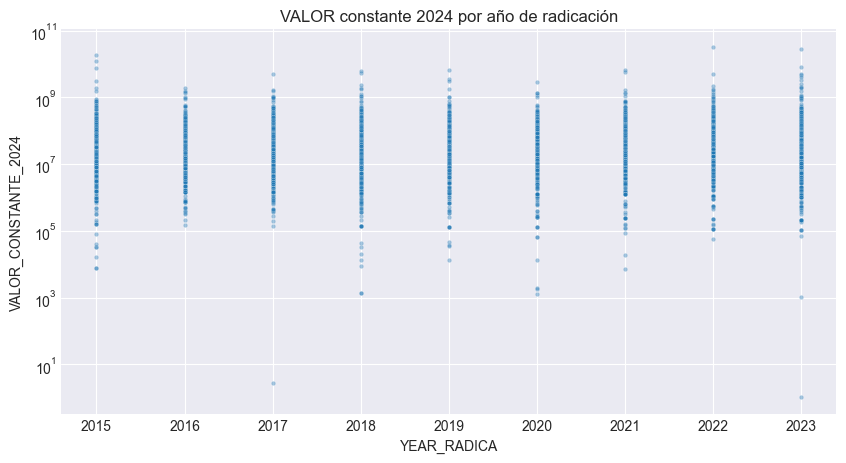

In [8]:
print("📈 Diagnóstico rápido del dataset estandarizado")

lf_std = pl.scan_parquet(output_path)

# 1. Resumen de VALOR y VALOR_CONSTANTE
print("\nResumen de VALOR y VALOR_CONSTANTE:")

df_std = (
    lf_std.select(
        pl.col("VALOR").alias("VALOR_original"), pl.col(f"VALOR_CONSTANTE_{BASE_YEAR}")
    ).collect()  # ← antes hacías .describe() aquí; ahora solo collect
)

print(df_std.describe())  # ← describe sobre DataFrame, no sobre LazyFrame

# 2. Distribución de rangos de precio (esto ya estaba bien)
print("\nDistribución de RANGO_PRECIO:")
print(
    lf_std.group_by("RANGO_PRECIO")
    .agg(pl.len().alias("count"))
    .sort("count", descending=True)
    .collect()
)

# 3. Gráfica simple (muestra)
df_sample = (
    lf_std.select(
        "YEAR_RADICA", "VALOR", f"VALOR_CONSTANTE_{BASE_YEAR}"
    ).collect()  # ← primero colectas todo
)

n = min(5000, df_sample.height)  # ← evitar error si hay menos de 5000 filas
df_sample = df_sample.sample(n=n, with_replacement=False).to_pandas()

plt.figure(figsize=(10, 5))
sns.scatterplot(
    data=df_sample, x="YEAR_RADICA", y=f"VALOR_CONSTANTE_{BASE_YEAR}", alpha=0.4, s=10
)
plt.title(f"VALOR constante {BASE_YEAR} por año de radicación")
plt.yscale("log")
plt.show()

In [9]:
import polars as pl
from utils.config import STANDARDIZED_PARQUET_FILE

print("📊 Resumen final del dataset estandarizado")
print("=========================================")

lf_std = pl.scan_parquet(STANDARDIZED_PARQUET_FILE)

# 1. Número total de filas y columnas
res = lf_std.select(pl.len().alias("num_filas")).collect()
num_filas = res["num_filas"][0]
num_cols = len(lf_std.collect_schema().names())

print(f"Filas totales       : {num_filas:,}")
print(f"Columnas totales    : {num_cols}")

# 2. Nulos en columnas clave
cols_clave = ["VALOR", f"VALOR_CONSTANTE_{BASE_YEAR}", "RANGO_PRECIO", "YEAR_RADICA", "MUNICIPIO", "DEPARTAMENTO"]
cols_exist = [c for c in cols_clave if c in lf_std.collect_schema().names()]

nulls_clave = (
    lf_std.select([pl.col(c).null_count().alias(c) for c in cols_exist])
    .collect()
    .to_dicts()[0]
)

print("\nNulos por columna clave:")
for c in cols_exist:
    print(f"  {c:25s}: {nulls_clave[c]:,}")

# 3. Distribución de RANGO_PRECIO (si existe)
if "RANGO_PRECIO" in cols_exist:
    dist_rango = (
        lf_std.group_by("RANGO_PRECIO")
        .agg(pl.len().alias("count"))
        .sort("count", descending=True)
        .collect()
    )
    print("\nDistribución de RANGO_PRECIO:")
    print(dist_rango)


📊 Resumen final del dataset estandarizado
Filas totales       : 5,778,058
Columnas totales    : 26

Nulos por columna clave:
  VALOR                    : 0
  VALOR_CONSTANTE_2024     : 0
  RANGO_PRECIO             : 0
  YEAR_RADICA              : 0
  MUNICIPIO                : 0
  DEPARTAMENTO             : 0

Distribución de RANGO_PRECIO:
shape: (4, 2)
┌──────────────┬─────────┐
│ RANGO_PRECIO ┆ count   │
│ ---          ┆ ---     │
│ str          ┆ u32     │
╞══════════════╪═════════╡
│ BAJO         ┆ 3391541 │
│ MEDIO        ┆ 1756604 │
│ ALTO         ┆ 551343  │
│ LUJO         ┆ 78570   │
└──────────────┴─────────┘
